# Part 2: Time Series Modeling

In this notebook, you will implement functions to extract features from time series data and build ARIMA models.

In [23]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pathlib import Path
import os

# Set style for plots
sns.set_theme()
%matplotlib inline

## 1. Feature Extraction

Implement the `extract_time_series_features` function to calculate rolling window features.

In [3]:
processed_data = pd.read_csv('data/processed/preprocessed_data.csv')

def extract_time_series_features(data, window_size=60):
    """Extract rolling window features from time series data.
    
    Parameters
    ----------
    data : pd.DataFrame
        Preprocessed physiological data
    window_size : int
        Size of the rolling window in seconds
        
    Returns
    -------
    pd.DataFrame
        DataFrame containing extracted features for each signal
    
    IMPORTANT_NOTE: Limited autocorrelation to just temperature to limit computational cost
    """
    new_data = pd.DataFrame()
    numeric_cols = ['heart_rate', 'eda', 'temperature']

    for column in numeric_cols:
        new_data[f'{column}_rolling_mean'] = data[column].rolling(window_size).mean()
        new_data[f'{column}_rolling_std'] = data[column].rolling(window_size).std()
        new_data[f'{column}_rolling_min'] = data[column].rolling(window_size).min()
        new_data[f'{column}_rolling_max'] = data[column].rolling(window_size).max()
    
    new_data['temperature_autocorrection'] = data['temperature'].rolling(window_size).apply(lambda x: x.autocorr(lag=1))

    new_data['subject_id'] = data['subject_id']
    new_data['session'] = data['session']

    new_data = new_data.dropna()

    return new_data

    

    # Your code here
    # 1. Calculate rolling window statistics
    # 2. Include mean, std, min, max, and autocorrelation


## 2. ARIMA Modeling

Implement the `build_arima_model` function to fit ARIMA models and generate diagnostic plots.

In [22]:
#ADF test to check for stationarity
from statsmodels.tsa.stattools import adfuller

small_data = processed_data['eda'].dropna().iloc[:5000]
result = adfuller(small_data)

print(f"ADF statisic: {result[0]}")
print(f"p-value: {result[1]}")

ADF statisic: -211.94313418018265
p-value: 0.0


/home/codespace/.local/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:955: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2


/tmp/ipykernel_32442/3817599037.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  processed_data['eda'] = processed_data['eda'].replace(0, np.nan).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


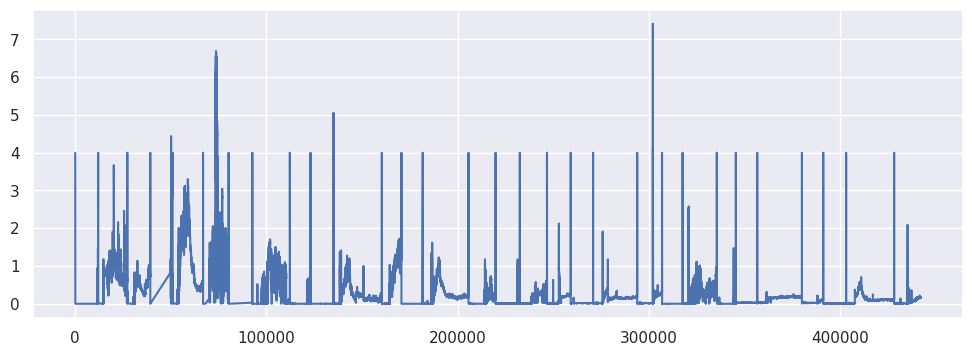

In [21]:
#Investigation of zeros in EDA readings - readings drop to exactly 0 a bunch - artifacts?

processed_data['eda'] = processed_data['eda'].replace(0, np.nan).interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
plt.figure(figsize=(12, 4))
plt.plot(processed_data['eda'])
plt.show()

In [27]:
def build_arima_model(series, order=(1,1,1), subject_id = 'S1', session = 'Midterm 1', signal_name = 'heart_rate', output_dir='/workspaces/4-it-s-about-time-rishim3000/data/plots'):
    """Fit an ARIMA model to the time series and generate diagnostic plots.
    
    Parameters
    ----------
    series : pd.Series
        Time series data to model
    order : tuple
        (p,d,q) order of the ARIMA model
    output_dir : str
        Directory to save diagnostic plots
        
    Returns
    -------
    statsmodels.tsa.arima.model.ARIMAResults
        Fitted ARIMA model
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    base_name = f"{subject_id}_{session}_{signal_name}".replace(" ", "_")
    
    # Your code here
    # 1. Fit ARIMA model

    model = sm.tsa.ARIMA(series, order=order)
    model_fit = model.fit()

    plt.figure(figsize = (12,6))
    plt.plot(series, label = 'Observed')
    plt.plot(model_fit.fittedvalues, label = 'Fitted Values', alpha = 0.7)
    plt.title(f'ARIMA Fit: {signal_name} ({subject_id} - {session})')
    plt.legend()
    #save figure to path
    fit_path = os.path.join(output_dir, f"{base_name}_arima_fit.png")
    plt.savefig(fit_path)
    plt.close()

    #Residuals
    residuals = model_fit.resid
    fig, ax = plt.subplots(figsize =(8,4))
    plot_acf(residuals, ax=ax, lags=40)
    ax.set_title(f'Residual ACF: {signal_name} ({subject_id} - {session})')
    residuals_path = os.path.join(output_dir, f"{base_name}_arima_residuals.png")
    plt.savefig(residuals_path)
    plt.close()

    print(f'Plots saved to: \n - {fit_path}\n - {residuals_path}')

    return model_fit

build_arima_model(series=processed_data[(processed_data['subject_id'] == 'S1') &
                                        (processed_data['session'] == 'Midterm 1')]['heart_rate'],
                  order=(1, 1, 1),
                  subject_id='S1',
                  session='Midterm 1',
                  signal_name='heart_rate',
                  output_dir = '/workspaces/4-it-s-about-time-rishim3000/data/plots')

/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/home/codespace/.local/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Plots saved to: 
 - /workspaces/4-it-s-about-time-rishim3000/data/plots/S1_Midterm_1_heart_rate_arima_fit.png
 - /workspaces/4-it-s-about-time-rishim3000/data/plots/S1_Midterm_1_heart_rate_arima_residuals.png
